In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [ ]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import json

dataset = load_dataset('multi_eurlex', language='en',label_level='level_2',trust_remote_code=True)
dataset3 = load_dataset('multi_eurlex', language='fr',label_level='level_2',trust_remote_code=True)

df=pd.DataFrame(dataset['train'])
df2=pd.DataFrame(dataset3['validation'])

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [ ]:
alls=[]
for a in df['labels']:
  alls.extend(a)
labels=np.array(list(range(np.max(alls)+1)))
dico=json.load(open('drive/MyDrive/eurovoc_descriptors.json'))
classlabel=dataset['train'].features['labels'].feature
meanings=[dico[lab]['en'] for lab in classlabel.int2str(labels)]

for label in labels:
  df[meanings[label]]=df['labels'].apply(lambda x: label in x)
  df2[meanings[label]]=df2['labels'].apply(lambda x: label in x)

df=df.drop(columns=['labels','celex_id'])
df2=df2.drop(columns=['labels','celex_id'])

<ipython-input-5-f7f225658481>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[meanings[label]]=df['labels'].apply(lambda x: label in x)
<ipython-input-5-f7f225658481>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[meanings[label]]=df2['labels'].apply(lambda x: label in x)
<ipython-input-5-f7f225658481>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inste

In [ ]:

import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset,random_split


In [ ]:
model_name = "FacebookAI/xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
encoded_inputs=tokenizer.batch_encode_plus(list(df.text),max_length=512, padding='max_length',truncation=True)
labels=torch.tensor(df.drop(columns=['text']).values,dtype=torch.float)
encoded_inputs_val=tokenizer.batch_encode_plus(list(df2.text),max_length=512, padding='max_length',truncation=True)
labels_val=torch.tensor(df2.drop(columns=['text']).values,dtype=torch.float)
full_set=TensorDataset(torch.tensor(encoded_inputs['input_ids']),torch.tensor(encoded_inputs['attention_mask']),labels)
full_test_set=TensorDataset(torch.tensor(encoded_inputs_val['input_ids']),torch.tensor(encoded_inputs_val['attention_mask']),labels_val)
train,val=random_split(full_set,[int(0.8*len(full_set)),len(full_set)-int(0.8*len(full_set))])
train_loader=DataLoader(train,batch_size=8,shuffle=True)
val_loader=DataLoader(val,batch_size=8,shuffle=False)
test_loader=DataLoader(full_test_set,batch_size=8,shuffle=False)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [ ]:

def r_precision(y_true, y_pred):
    positives = (y_true == 1.0).sum(dim=1)
    sorted_indices = torch.argsort(y_pred, dim=1, descending=True)
    y_true_sorted = torch.gather(y_true, dim=1, index=sorted_indices)
    batch_size = y_true.size(0)
    relevant_counts = []
    for i in range(batch_size):
        k = int(positives[i].item())
        if k == 0:
            relevant_counts.append(torch.tensor(0.0, device=y_true.device))
        else:
            top_k = y_true_sorted[i][:k]
            relevant_counts.append(top_k.sum())

    relevant = torch.stack(relevant_counts)

    # Avoid division by zero
    r_precision_scores = torch.where(positives > 0, relevant / positives, torch.zeros_like(relevant))
    return r_precision_scores

In [25]:
def train_model(freeze_layers=False):
  model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=127)
  model.train()
  if freeze_layers:
    optimizer=torch.optim.Adam(model.parameters(),lr=2e-5)
  else:
    optimizer=torch.optim.Adam(model.parameters(),lr=3e-5)
  device=torch.device('cuda')
  model=model.to(device)
  loss_fn=nn.BCEWithLogitsLoss()
  if freeze_layers:
    model.roberta.embeddings.trainable = False
    for i in range(6):
        model.roberta.encoder.layer[i].attention.self.trainable = False
        model.roberta.encoder.layer[i].attention.output.dense.trainable = False
        model.roberta.encoder.layer[i].attention.output.LayerNorm.trainable = False
        model.roberta.encoder.layer[i].intermediate.trainable = False
        model.roberta.encoder.layer[i].output.dense.trainable = False
        model.roberta.encoder.layer[i].output.LayerNorm.trainable = False

  best_val_loss=1000
  alosses=[]
  aval_losses=[]
  for epoch in range(1,10):
    losses=[]
    model.train()
    for step,(input_ids,attention_mask,labe) in enumerate(train_loader):
      optimizer.zero_grad()
      outputs=model(input_ids=input_ids.to(device),attention_mask=attention_mask.to(device))
      loss=loss_fn(outputs.logits,labe.to(device))
      loss.backward()
      optimizer.step()
      losses.append(float(loss.cpu().detach()))
    model.eval()
    val_losses=[]
    val_accs=[]
    r_scores=[]
    with torch.no_grad():
      for step,(input_ids,attention_mask,labe) in enumerate(val_loader):
        outputs=model(input_ids=input_ids.to(device),attention_mask=attention_mask.to(device))
        loss=loss_fn(outputs.logits,labe.to(device))
        val_losses.append(float(loss.cpu()))
        targ_labs=(outputs.logits>0).float().cpu()
        val_accs.append((targ_labs==labe.cpu()).float().mean())
        r_score=r_precision(labe.cpu(),outputs.logits.cpu())
        r_scores.append(r_score)

    vloss=np.array(val_losses).mean()
    loss=np.array(losses).mean()
    alosses.append(loss)
    aval_losses.append(vloss)
    r_score=np.array(r_scores).mean()
    print(f'Epoch {epoch}: Loss={loss:0.4f}; Val Loss={vloss:0.4f}; Val accuracy={np.array(val_accs).mean():0.4f}; R={r_score:0.4f}')

    val_losses=[]
    val_accs=[]
    r_scores=[]
    with torch.no_grad():
      for step,(input_ids,attention_mask,labe) in enumerate(test_loader):
        outputs=model(input_ids=input_ids.to(device),attention_mask=attention_mask.to(device))
        loss=loss_fn(outputs.logits,labe.to(device))
        val_losses.append(float(loss.cpu()))
        targ_labs=(outputs.logits>0).float().cpu()
        val_accs.append((targ_labs==labe.cpu()).float().mean())
        r_score=r_precision(labe.cpu(),outputs.logits.cpu())
        r_scores.append(r_score)

    vloss=np.array(val_losses).mean()
    r_score=np.array(r_scores).mean()
    print(f'Test on french: Val Loss={vloss:0.4f}; Val accuracy={np.array(val_accs).mean():0.4f}; R={r_score:0.4f}')

    if vloss<best_val_loss:
      best_val_loss=vloss
      if freeze_layers:
        torch.save(model.state_dict(),'drive/MyDrive/best_model_frozen.pt')
      else:
        torch.save(model.state_dict(),'drive/MyDrive/best_model_nonfrozen.pt')
      print('Saving model')
  return alosses,aval_losses

In [26]:
l1,vl1=train_model(True)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Loss=0.1048; Val Loss=0.0680; Val accuracy=0.9783; R=0.6698
Test on french: Val Loss=0.0900; Val accuracy=0.9700; R=0.5738
Saving model
Epoch 2: Loss=0.0606; Val Loss=0.0532; Val accuracy=0.9826; R=0.7463
Test on french: Val Loss=0.0804; Val accuracy=0.9721; R=0.5854
Saving model
Epoch 3: Loss=0.0503; Val Loss=0.0473; Val accuracy=0.9843; R=0.7767
Test on french: Val Loss=0.0731; Val accuracy=0.9753; R=0.6587
Saving model
Epoch 4: Loss=0.0447; Val Loss=0.0443; Val accuracy=0.9850; R=0.7886
Test on french: Val Loss=0.0708; Val accuracy=0.9760; R=0.6825
Saving model
Epoch 5: Loss=0.0407; Val Loss=0.0421; Val accuracy=0.9857; R=0.8013
Test on french: Val Loss=0.0705; Val accuracy=0.9764; R=0.6690
Saving model
Epoch 6: Loss=0.0375; Val Loss=0.0410; Val accuracy=0.9860; R=0.8066
Test on french: Val Loss=0.0718; Val accuracy=0.9758; R=0.6665
Epoch 7: Loss=0.0348; Val Loss=0.0401; Val accuracy=0.9863; R=0.8143
Test on french: Val Loss=0.0749; Val accuracy=0.9749; R=0.6532
Epoch 8: Lo

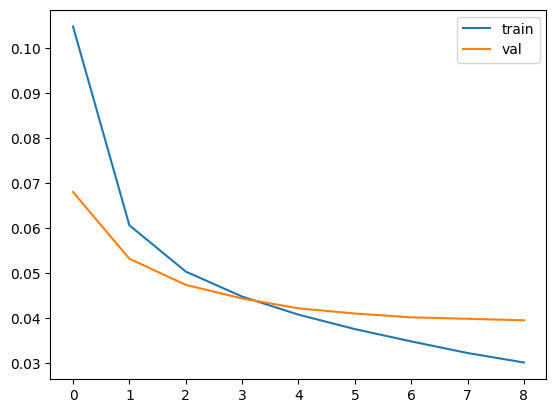

In [27]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(l1,label='train')
plt.plot(vl1,label='val')
plt.legend()
plt.show()

In [ ]:
l2,vl2=train_model(False)